In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="darkgrid") 
sns.set_context("notebook", font_scale=1.1)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

CHECKPOINT_DIR = Path("./artifacts")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = CHECKPOINT_DIR / "best_resnet_soil.pth"

## 1. EDA — Image dataset

In [2]:
from pathlib import Path

# Include both original and augmented image datasets
IMAGE_ROOTS = [
    Path("./data/soil_images/Orignal-Dataset"),
    Path("./data/soil_images/CyAUG-Dataset"),
]

image_paths = []
for root in IMAGE_ROOTS:
    image_paths.extend(root.glob("*/*"))

if len(image_paths) == 0:
    raise FileNotFoundError(f"No images found under {IMAGE_ROOTS} – check paths or download.")

img_records = []
for p in image_paths:
    label = p.parent.name
    img_records.append((str(p), label, p.parent.parent.name))  # filepath, label, source

img_df = pd.DataFrame(img_records, columns=["filepath", "label", "source"])
print("Image dataset shape:", img_df.shape)
print("Source split:\n", img_df["source"].value_counts())
print("Label counts:\n", img_df["label"].value_counts())
print("Sample rows:")
display(img_df.sample(5, random_state=0))

Image dataset shape: (6286, 3)
Source split:
 source
CyAUG-Dataset      5097
Orignal-Dataset    1189
Name: count, dtype: int64
Label counts:
 label
Yellow_Soil      1470
Black_Soil       1428
Red_Soil         1235
Alluvial_Soil     745
Arid_Soil         568
Laterite_Soil     438
Mountain_Soil     402
Name: count, dtype: int64
Sample rows:


,filepath,label,source
4230,data/soil_images/CyAUG-Dataset/Alluvial_Soil/a...,Alluvial_Soil,CyAUG-Dataset
4292,data/soil_images/CyAUG-Dataset/Alluvial_Soil/a...,Alluvial_Soil,CyAUG-Dataset
3362,data/soil_images/CyAUG-Dataset/Yellow_Soil/y (...,Yellow_Soil,CyAUG-Dataset
2434,data/soil_images/CyAUG-Dataset/Black_Soil/156.jpg,Black_Soil,CyAUG-Dataset
5883,data/soil_images/CyAUG-Dataset/Red_Soil/r (283...,Red_Soil,CyAUG-Dataset


## 2. EDA — Tabular datasets

In [3]:
d = pd.read_csv('./data/tabular/d1.csv')

In [4]:
d['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [5]:
d.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00
mean,50.55,53.36,48.15,25.62,71.48,6.47,103.46
std,36.92,32.99,50.65,5.06,22.26,0.77,54.96
min,0.00,5.00,5.00,8.83,14.26,3.50,20.21
25%,21.00,28.00,20.00,22.77,60.26,5.97,64.55
50%,37.00,51.00,32.00,25.60,80.47,6.43,94.87
75%,84.25,68.00,49.00,28.56,89.95,6.92,124.27
max,140.00,145.00,205.00,43.68,99.98,9.94,298.56


In [6]:
d.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.88,82.00,6.50,202.94,rice
1,85,58,41,21.77,80.32,7.04,226.66,rice
2,60,55,44,23.00,82.32,7.84,263.96,rice
3,74,35,40,26.49,80.16,6.98,242.86,rice
4,78,42,42,20.13,81.60,7.63,262.72,rice


In [7]:
d_numeric = d.select_dtypes(include='number')

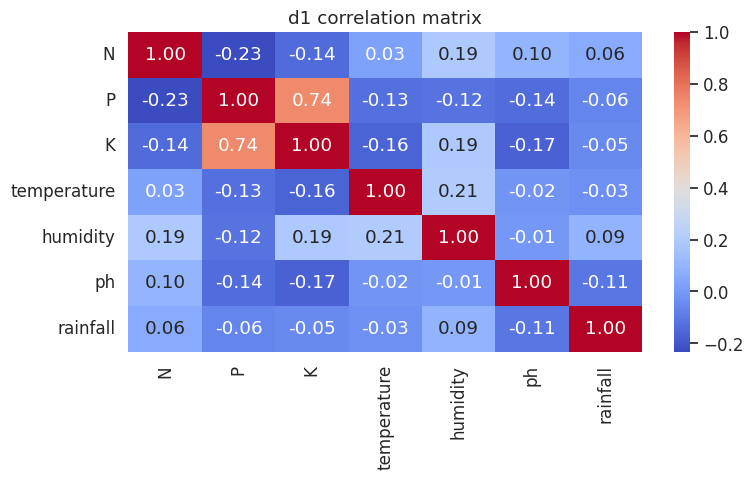

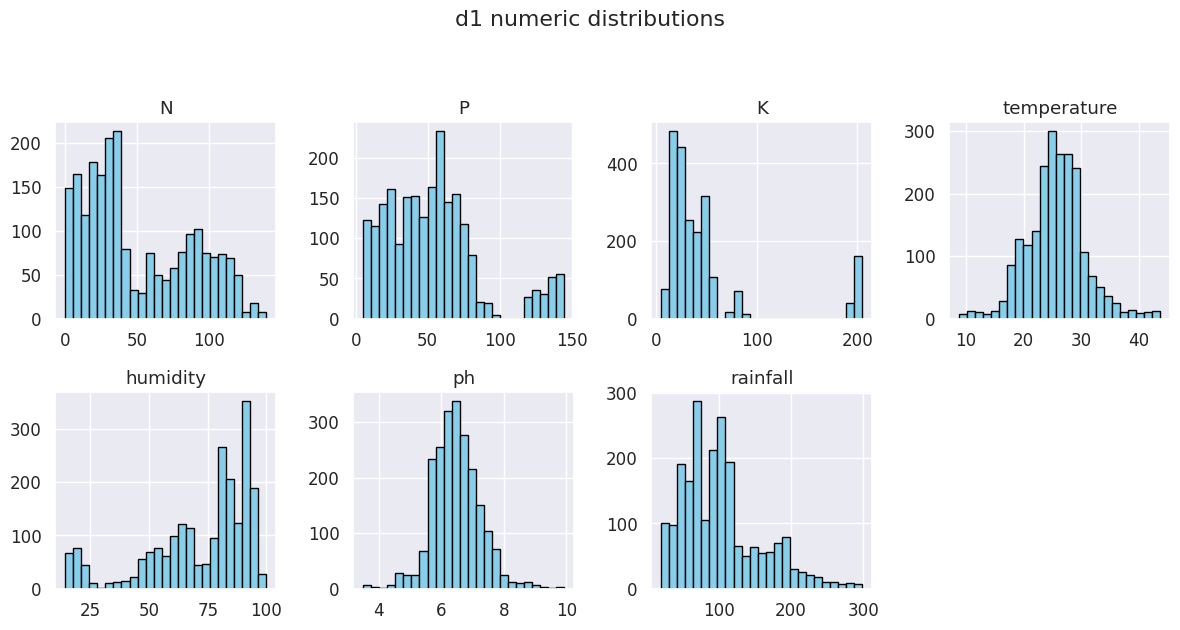

In [8]:
corr = d_numeric.corr()
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('d1 correlation matrix')
plt.tight_layout()
plt.show()

d_numeric.hist(bins=25, figsize=(12, 6), layout=(2, 4), color='skyblue', edgecolor='black')
plt.suptitle('d1 numeric distributions', y=1.05)
plt.tight_layout()
plt.show()

## 3. Image model: soil-type classifier
We train a ResNet50 on the soil image dataset and keep the best checkpoint for downstream soil-type inference.

In [9]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    img_df,
    test_size=0.2,
    stratify=img_df["label"],
    random_state=42,
)
val_rel = 0.1 / 0.8  # 10% of total reserved for val
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_rel,
    stratify=train_val_df["label"],
    random_state=42,
)

class_names = sorted(img_df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
num_classes = len(class_names)

print({"train": len(train_df), "val": len(val_df), "test": len(test_df)})

{'train': 4399, 'val': 629, 'test': 1258}


In [10]:
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class SoilImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filepath"]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = class_to_idx[row["label"]]
        return image, label

train_dataset = SoilImageDataset(train_df, transform=train_transform)
val_dataset = SoilImageDataset(val_df, transform=val_test_transform)
test_dataset = SoilImageDataset(test_df, transform=val_test_transform)

NUM_WORKERS = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Device: cuda


In [11]:
from copy import deepcopy
import time
from sklearn.metrics import classification_report, confusion_matrix


def train_image_model(num_epochs=5, lr=1e-3):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_wts = deepcopy(model.state_dict())
    best_val_acc = 0.0

    if CKPT_PATH.exists():
        model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
        print("Loaded ResNet50 checkpoint from", CKPT_PATH)
        return model

    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double().item() / len(train_loader.dataset)

        model.eval()
        val_corrects = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double().item() / len(val_loader.dataset)

        elapsed = time.time() - start
        print(f"Epoch {epoch+1}/{num_epochs} | train loss {train_loss:.4f} acc {train_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f} | {elapsed:.1f}s")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wts = deepcopy(model.state_dict())

    model.load_state_dict(best_wts)
    return model

image_model = train_image_model(num_epochs=5, lr=1e-3)


Loaded ResNet50 checkpoint from artifacts/best_resnet_soil.pth


Test classification report:

               precision    recall  f1-score   support

Alluvial_Soil       0.98      0.40      0.57       149
    Arid_Soil       0.62      0.97      0.76       114
   Black_Soil       0.99      0.98      0.99       286
Laterite_Soil       0.76      0.91      0.83        88
Mountain_Soil       0.75      1.00      0.86        80
     Red_Soil       0.98      0.98      0.98       247
  Yellow_Soil       0.95      0.90      0.92       294

     accuracy                           0.89      1258
    macro avg       0.86      0.88      0.84      1258
 weighted avg       0.91      0.89      0.88      1258



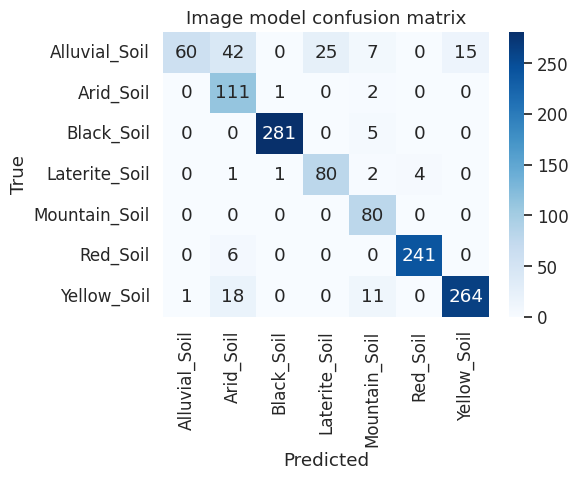

In [12]:
# Evaluate on held-out test set
image_model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = image_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

print("Test classification report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Image model confusion matrix")
plt.tight_layout()
plt.show()

## 4. Tabular Model: Crop Recommender

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def preprocess_tabular(df):
    X = df.drop(columns=["label"]).copy()
    y = df["label"].copy()

    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(y)

    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    feat_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        feat_encoders[col] = le

    medians = X.median(numeric_only=True)
    X = X.fillna(medians)
    X = X.astype(float)

    return X, y_enc, label_encoder, feat_encoders, medians, cat_cols


Training XGBoost (rows=2200):
validation accuracy: 0.991

Classification report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       1.00      1.00      1.00        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.85      0.92        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.91      1.00      0.95        20
    mungbean       0.95      1.00      0.98        20
   muskmelon       1.00      1.00      1.00        2

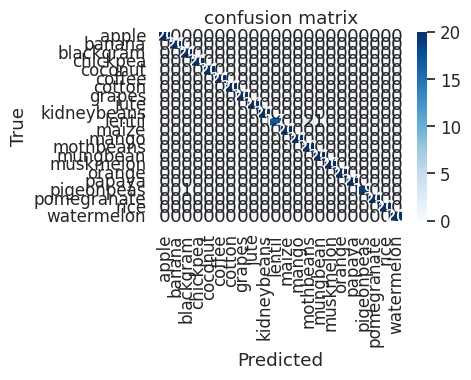

In [14]:
df = d
print(f"\nTraining XGBoost (rows={df.shape[0]}):")
X, y_enc, label_encoder, feat_encoders, medians, cat_cols = preprocess_tabular(df)

X_train, X_val, y_train, y_val = train_test_split(
    X.values,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc,
)

classes, counts = np.unique(y_enc, return_counts=True)
class_weights = {cls: len(y_enc) / (len(classes) * count) for cls, count in zip(classes, counts)}
train_weights = np.array([class_weights[c] for c in y_train])

num_classes = len(label_encoder.classes_)
clf = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=2,
    gamma=0.1,
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric=["mlogloss", "merror"],
    tree_method="hist",
    random_state=42,
)

clf.fit(
    X_train,
    y_train,
    sample_weight=train_weights,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

y_pred = clf.predict_proba(X_val).argmax(axis=1)
acc = accuracy_score(y_val, y_pred)
print(f"validation accuracy: {acc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"confusion matrix")
plt.tight_layout()
plt.show()

meta = {
    "label_encoder": label_encoder,
    "feat_encoders": feat_encoders,
    "medians": medians,
    "cat_cols": cat_cols,
    "feature_order": X.columns.tolist(),
}

xgb_model = {"model": clf, "meta": meta}

## 4. Complete pipline
Classify soil type from the image, predict top-K crops suitable for the given geological and environmental conditions, and the by using knowledge based domain, verify whether the recommended can be grown on the given soil.

In [15]:
SOIL_TYPE_DOMAIN_KNOWLEDGE = {
    "Alluvial_Soil": [
        "rice", "maize", "cotton", "jute", "pigeonpeas", "mungbean", "blackgram", "lentil", 
        "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", "watermelon", 
        "muskmelon", "apple", "orange", "papaya", "coconut", "coffee"
    ],

    "Black_Soil": [
        "cotton", "maize", "pigeonpeas", "mungbean", "blackgram", "lentil", "chickpea", 
        "kidneybeans", "mothbeans", "orange", "papaya"
    ],
    
    "Red_Soil": [
        "cotton", "rice", "maize", "pigeonpeas", "mungbean", "blackgram", "lentil", 
        "chickpea", "kidneybeans", "mothbeans", "pomegranate", "banana", "mango", 
        "grapes", "watermelon", "muskmelon", "apple", "orange", "papaya", "coconut", "coffee"
    ],
    
    "Laterite_Soil": ["coffee", "coconut", "rice", "maize", "pigeonpeas", "mungbean", "blackgram", 
        "lentil", "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", "watermelon", 
        "muskmelon", "apple", "orange", "papaya"
    ],
    
    "Arid_Soil": ["maize", "cotton", "pigeonpeas", "mungbean", "blackgram", "lentil", 
        "chickpea", "kidneybeans", "mothbeans", "pomegranate", "banana", "mango", "grapes", 
        "watermelon", "muskmelon", "apple", "orange", "papaya"
    ],
    
    "Mountain_Soil": ["coffee", "maize", "rice", "pigeonpeas", "mungbean", "blackgram", 
        "lentil", "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", 
        "watermelon", "muskmelon", "apple", "orange", "papaya"
    ],
    
    "Yellow_Soil": ["rice", "cotton", "jute", "pigeonpeas", "mungbean", "blackgram", 
        "lentil", "chickpea", "kidneybeans", "pomegranate", "banana", "mango", "grapes", 
        "watermelon", "muskmelon", "apple", "orange", "papaya", "coconut", "coffee"
    ]
}

In [16]:
import torch.nn.functional as F

def predict_soil_type(image_path):
    image_model.eval()
    image = Image.open(image_path).convert("RGB")
    tensor = val_test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = image_model(tensor)
        probs = F.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        pred_conf = probs.max().item()
    return idx_to_class[pred_idx], pred_conf


def encode_categorical(value, encoder):
    value = str(value)
    classes = list(encoder.classes_)
    if value in classes:
        return encoder.transform([value])[0]
    return encoder.transform([classes[0]])[0]


def prepare_tabular_input(features):
    meta = xgb_model["meta"]
    feature_order = meta["feature_order"]
    cat_cols = set(meta["cat_cols"])
    feat_encoders = meta["feat_encoders"]
    medians = meta["medians"]

    row = {}
    for col in feature_order:
        if col in features:
            row[col] = features[col]
        else:
            row[col] = medians[col] if col in medians else 0

    row_df = pd.DataFrame([row])

    for col in cat_cols:
        row_df[col] = row_df[col].astype(str).apply(lambda v: encode_categorical(v, feat_encoders[col]))

    for col in feature_order:
        if col not in row_df.columns:
            default_val = medians[col] if col in medians else 0
            row_df[col] = default_val

    row_df = row_df[feature_order]
    row_df = row_df.fillna(medians)
    row_df = row_df.astype(float)
    return row_df.values


def recommend_crop(image_path, tabular_features, dataset_name="d1", top_k=22):
    soil_label, soil_conf = predict_soil_type(image_path)

    sample_x = prepare_tabular_input(tabular_features)
    model = xgb_model["model"]
    label_encoder = xgb_model["meta"]["label_encoder"]

    proba = model.predict_proba(sample_x)[0]
    top_indices = proba.argsort()[::-1][:top_k]
    top_crops = label_encoder.inverse_transform(top_indices)
    top_probs = proba[top_indices]

    compatible_crops = SOIL_TYPE_DOMAIN_KNOWLEDGE.get(soil_label, [])
    compatible_crops_lower = [c.lower() for c in compatible_crops]
    
    final_recommendations = []
    for crop, prob in zip(top_crops, top_probs):
        is_compatible = crop.lower() in compatible_crops_lower
        final_recommendations.append({
            "crop": crop,
            "probability": float(prob),
            "is_compatible_with_soil": is_compatible
        })

    return {
        "soil_prediction": soil_label,
        "soil_confidence": soil_conf,
        "top_recommendations": final_recommendations,
        "tabular_dataset_used": dataset_name,
    }

## 5. Final testing 

In [17]:
example_image_path = "./data/soil_images/Orignal-Dataset/Black_Soil/1.jpg" 
base_features = d.drop(columns=['label']).median(numeric_only=True).to_dict()
result = recommend_crop(example_image_path, base_features, dataset_name='d1', top_k=5)

print(f"Predicted Soil Type: {result['soil_prediction']} (Conf: {result['soil_confidence']:.2f})")
print("\nTop Crop Recommendations:")
for rec in result['top_recommendations']:
    status = "Compatible" if rec['is_compatible_with_soil'] else "Soil Mismatch"
    print(f"- {rec['crop']} ({rec['probability']:.2%}) -> {status}")

Predicted Soil Type: Black_Soil (Conf: 1.00)

Top Crop Recommendations:
- muskmelon (6.99%) -> Soil Mismatch
- chickpea (6.16%) -> Compatible
- grapes (5.73%) -> Soil Mismatch
- apple (5.60%) -> Soil Mismatch
- orange (5.57%) -> Compatible
